### Test basic functionality, using data from a 2D LTI

In [1]:
import numpy as np
import math
import scipy

from matplotlib import pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('font', size=20)

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader

import os
import argparse
import time
from tqdm import tqdm # Loading bar
print('Done.')

In [2]:
from utils import complex_conj_transpose, batched_complex_conj_transpose, complex_exp, complex_exp_v2, complex_hadamard, complex_matmul, complex_division
from utils import batched_complex_conj_transpose, batched_complex_hadamard, batched_complex_matmul, batched_complex_division
from utils import batched_complex_exp, batched_complex_hadamard_full, batched_complex_matmul_full
print('Done.')

Done.


In [3]:
from misc import f_pij_scalar
# from misc import construct_2D_rotation_matrix, construct_2D_unitary_matrix, construct_special_2D_unitary, construct_diag_matrix, construct_2D_normal_matrix, orthogonal_matrix_2D
print('Done')

Done


In [4]:
from dynamics import stochastic_LTI, construct_mapping
from dynamics import get_nth_measurement, get_random_measurements
print('Done.')

Done.


In [6]:
from precision_attention import compute_residuals, compute_kernel_v1, compute_estimates_and_residuals_vectorized, get_time_diffs, compute_neg_kernel, clamp_exponent_arg
from precision_attention import compute_kernel, batched_compute_estimates_and_residuals_vectorized, compute_estimates_and_residuals_irregular_times, compute_nu
from precision_attention import compute_precision_v1
from precision_attention import precise_attn, precise_attn_with_correction, precise_attn_full
print('Done.')

Done.


In [7]:
parser = argparse.ArgumentParser('DA')
parser.add_argument('--gpu', type=int, default=0) # (Default: 0)
args = parser.parse_args(args=[])
args.device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
print(args.device)

torch.manual_seed(2025)
np.random.seed(2025)

cuda:0


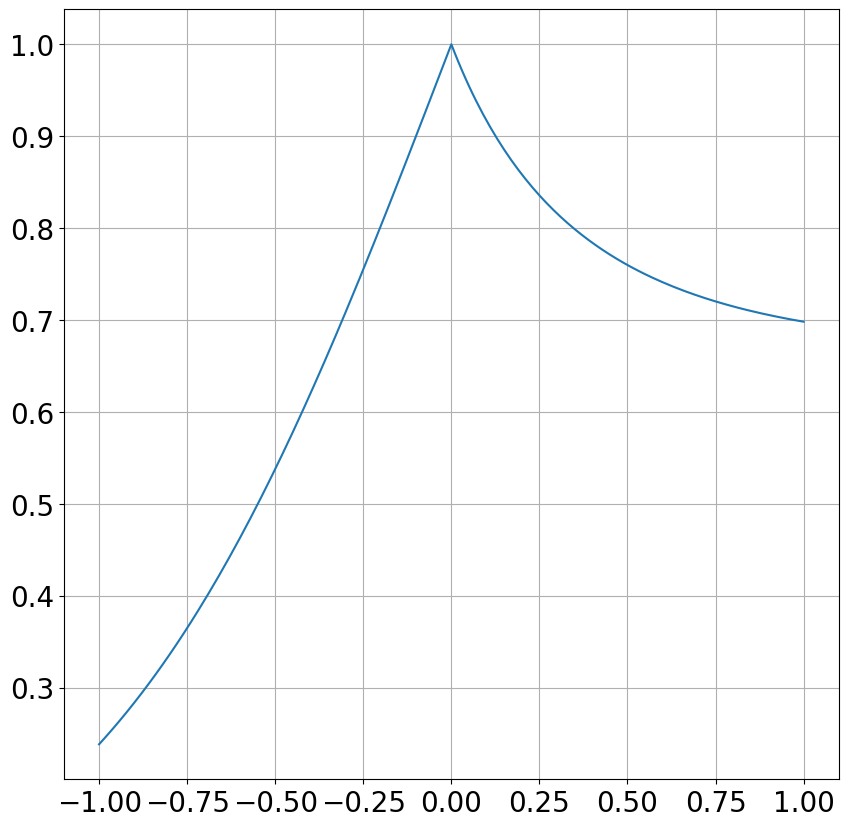

In [8]:
# Plot example of Precision in 2D

lambder = 1
lambda_Omega = 1
lambda_Omega0 = 1
nu = 1
tf = 1
args.dt = 0.01
Npts = int(tf/args.dt)
t_v = torch.linspace(-tf, tf, 2*Npts + 1)
pij = f_pij_scalar(lambder, lambda_Omega, lambda_Omega0, nu, t_v, 0)

plt.plot(t_v, pij)
plt.grid()
plt.show()

tensor([[[-8.7165],
         [ 1.1142]]], device='cuda:0')


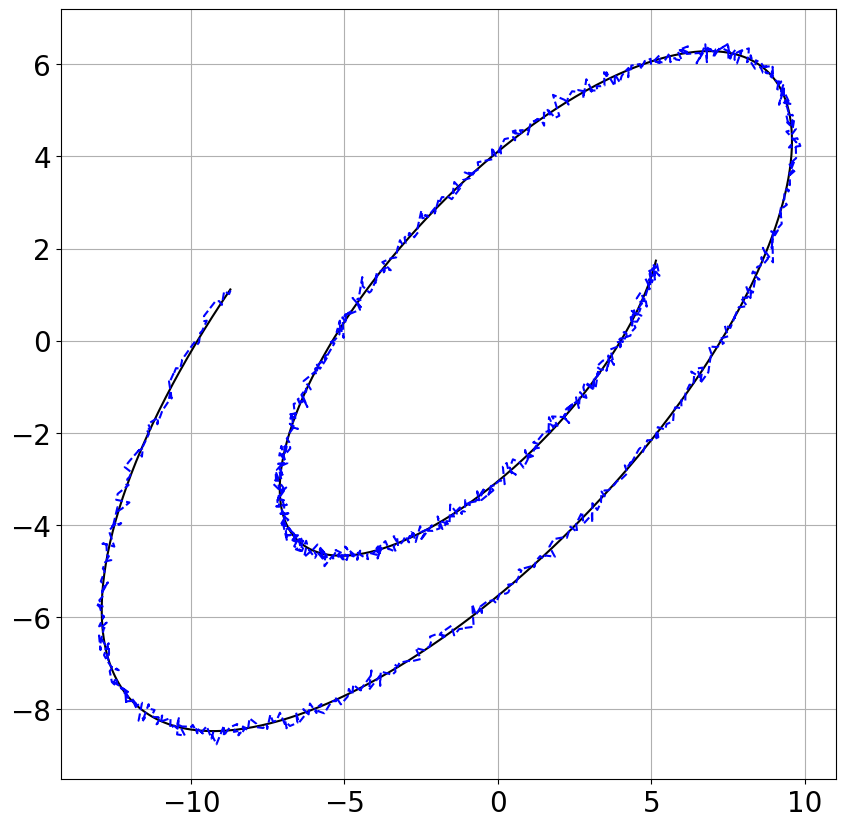

In [9]:
# Example dynamical system:

args.m = 2 # Dimension of system
args.tf = 10 # Final time
args.dt = 0.01 # Time step size
args.N_t = int(args.tf/args.dt) + 1 # Number of time steps
args.seq_len = args.N_t

t_v = torch.linspace(0, args.tf, args.N_t).to(args.device) # Vector of times

x0 = (torch.randn(args.m)*10).unsqueeze(0).unsqueeze(-1).to(args.device) # Initial condition
print(x0)

# Defines a stable 2D linear system:
D1 = torch.zeros(2,2,2).to(args.device) # Diagonal matrix
S1 = torch.zeros(2,2,2).to(args.device) # Unitary matrix
Si1 = torch.zeros(2,2,2).to(args.device) # Inverse of unitary matrix
D1[0] = torch.tensor([[-0.1, 0.0], [0.0, -0.1]]).to(args.device)
D1[1] = torch.tensor([[-1.0, 0.0], [0.0, 1.0]]).to(args.device)
S1[0] = torch.tensor([[1.0, 1.0], [1.0, 1.0]]).to(args.device)
S1[1] = torch.tensor([[-1.0, 1.0], [0.0, 0.0]]).to(args.device)
Si1[0] = 0.5*torch.tensor([[0.0, 1.0], [0.0, 1.0]]).to(args.device)
Si1[1] = 0.5*torch.tensor([[1.0, -1.0], [-1.0, 1.0]]).to(args.device)

D1 = D1.unsqueeze(1)
S1 = S1.unsqueeze(1)
Si1 = Si1.unsqueeze(1)

A = complex_matmul(S1,complex_matmul(D1,Si1))[0] # State transition matrix

sigma_process = 0.0
sigma_process_0 = 0.0
sigma_measure = 0.1
X_true, X_measure = stochastic_LTI(A, x0, args.N_t, args, sigma_process=sigma_process, sigma_process_0=sigma_process_0, sigma_measure = sigma_measure) # Simulate system

plt.plot(X_true.squeeze().T[0].detach().cpu().numpy(),X_true.squeeze().T[1].detach().cpu().numpy(), 'black')
plt.plot(X_measure.squeeze().T[0].detach().cpu().numpy(),X_measure.squeeze().T[1].detach().cpu().numpy(), 'b--')
plt.grid()
plt.show()

In [ ]:
# lambda_h = torch.randn(2, 2).to(args.device)/10
# lambda_h[0,0:2] = torch.diag(D1[0].squeeze())
# lambda_h[1,0:2] = torch.diag(D1[1].squeeze())
# lambda_h = lambda_h.unsqueeze(1).unsqueeze(-1)

# from scipy.linalg import expm
# A = complex_matmul(S1,complex_matmul(D1,Si1)) # State transition matrix
# A_t = (-A[0].unsqueeze(0)*t_v.unsqueeze(1).unsqueeze(2)).cpu().numpy()
# A_ts = (-A[0].T.unsqueeze(0)*t_v.unsqueeze(1).unsqueeze(2)).cpu().numpy()
# Lt = torch.exp(-2*lambda_h[0]*t_v.unsqueeze(1).unsqueeze(2))
# L_diag = torch.diag_embed(Lt.squeeze(-1)).cpu().numpy()

# mat_exp_A_t = expm(A_t)
# mat_exp_A_ts = expm(A_ts)
# v1 = np.matmul(mat_exp_A_t,mat_exp_A_ts)

# SS1 = (S1[0]+S1[1]*1j).unsqueeze(0).cpu().numpy()
# SSi1 = (Si1[0]+Si1[1]*1j).unsqueeze(0).cpu().numpy()
# v2 = np.matmul(np.matmul(SS1, L_diag),SSi1).real

# # plt.plot(v1[:,0,0],'b--')
# # plt.plot(v1[:,1,0],'b--')
# # plt.plot(v1[:,0,1],'b--')
# # plt.plot(v1[:,1,1],'b--')
# # plt.plot(v2[:,0,0],'r--')
# # plt.plot(v2[:,1,0],'r--')
# # plt.plot(v2[:,0,1],'r--')
# # plt.plot(v2[:,1,1],'r--')
# # plt.grid()
# # plt.show()

# v11int = np.cumsum(v1[:,0,0])
# v12int = np.cumsum(v1[:,1,0])
# v13int = np.cumsum(v1[:,0,1])
# v14int = np.cumsum(v1[:,1,1])
# v21int = np.cumsum(v2[:,0,0])
# v22int = np.cumsum(v2[:,1,0])
# v23int = np.cumsum(v2[:,0,1])
# v24int = np.cumsum(v2[:,1,1])

# plt.plot(v11int,'b--')
# plt.plot(v12int,'b--')
# # plt.plot(v13int,'b--')
# plt.plot(v14int,'b--')
# plt.plot(v21int,'r--')
# plt.plot(v22int,'r--')
# # plt.plot(v23int,'r--')
# plt.plot(v24int,'r--')
# plt.grid()
# plt.show()

In [10]:
# lambda_ht = lambda_h.transpose(-2,-1)

# s1 = (lambda_h + complex_conj_transpose(lambda_h).transpose(-2,-1)).unsqueeze(0)
# s1.size()

# G = complex_matmul(Si1, complex_conj_transpose(Si1))
# e_t = torch.exp(-s1 * t_v.unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4))
# e_t.size()

# t1 = batched_complex_division((1 - e_t),s1)
# t1
# M = batched_complex_hadamard(G, t1)

# V = batched_complex_matmul(batched_complex_matmul(S1,M),Si1)

# V_plt = V[:,0].squeeze().cpu().numpy()
# batched_complex_matmul(S1,M).size()

# # v31int = M[:,0,0]
# # v32int = M[:,1,0]
# # v33int = M[:,0,1]
# # v34int = M[:,1,1]

# # plt.plot(v11int,'b--')
# # plt.plot(v12int,'b--')
# # # plt.plot(v13int,'b--')
# # plt.plot(v14int,'b--')
# # plt.plot(v31int,'r--')
# # plt.plot(v32int,'r--')
# # # plt.plot(v33int,'r--')
# # plt.plot(v34int,'r--')
# # plt.grid()
# # plt.show()

Test mapping dynamics backward using matrix exponential

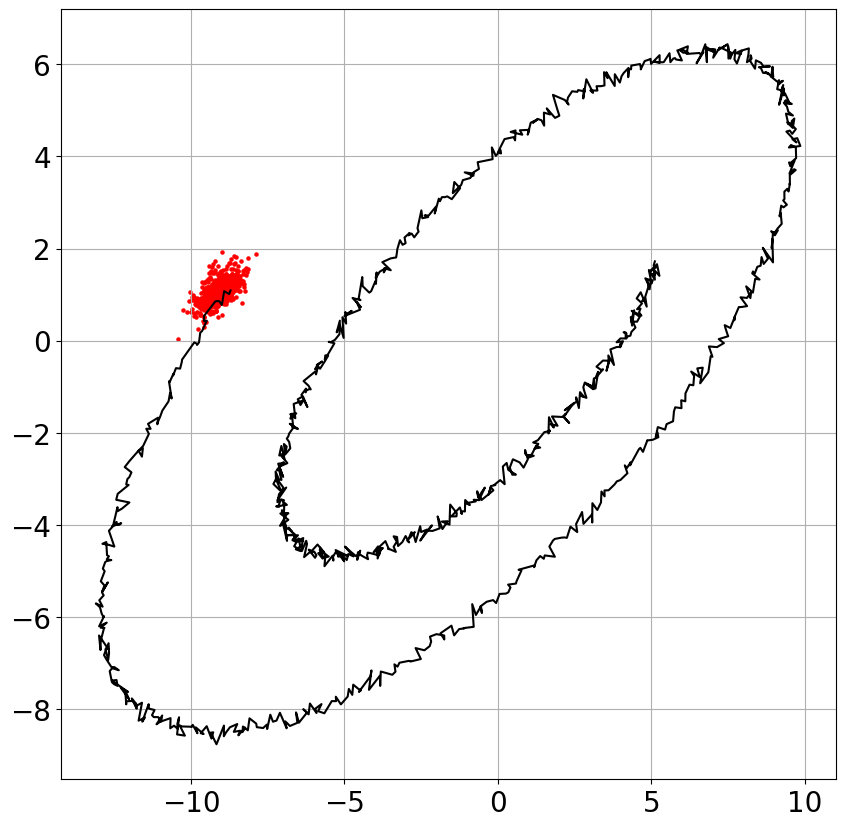

In [11]:
args.embed_dim = 2 # Embed dimension
args.d_v = args.embed_dim # Embed dimension

# lambda for this system can be pulled from D
lambda_h = torch.randn(2, args.embed_dim).to(args.device)/10
lambda_h[0,0:2] = torch.diag(D1[0].squeeze())
lambda_h[1,0:2] = torch.diag(D1[1].squeeze())
lambda_h = lambda_h.unsqueeze(1).unsqueeze(-1)

# Matrix exponentials
mat_exp_f = complex_exp(lambda_h*t_v.unsqueeze(0).unsqueeze(2).unsqueeze(3)) # Forward
mat_exp_b = complex_exp(-lambda_h*t_v.unsqueeze(0).unsqueeze(2).unsqueeze(3)) # Backward

##############################

# Construct matrices to map between higher/lower dimensions

Pu = torch.zeros(2, args.embed_dim, args.m).to(args.device)
Pd = torch.zeros(2, args.m, args.embed_dim).to(args.device)

# Xr = X_measure[0]
# Xi = X_measure[1]

Pu = Pu.unsqueeze(1)
Pd = Pd.unsqueeze(1)

Pu[:,:,0:2,:] = Si1
Pd[:,:,:,0:2] = S1

##############################

# Generate vals with matrix exponential
# y1 = complex_matmul(Si1,X0) # Map to eigenbasis
# y2 = complex_hadamard(mat_exp_2f,y1) # Mat exp
# y3 = complex_matmul(S1,y2) # Back to original basis

# y3 = X_measure # Use simulated values from stochastic LTI
X = torch.zeros((2,X_measure.size()[0], X_measure.size()[1], X_measure.size()[2])).to(args.device)
X[0] = X_measure
y4 = complex_matmul(Pu,X) # Map to higher dim
y5 = complex_hadamard(mat_exp_b,y4) # Negative mat exp in higher dim
y6 = complex_matmul(Pd,y5) # Map back to lower dim

yi = X[0].squeeze().detach().cpu().numpy()
y = y6[0].squeeze().detach().cpu().numpy()

plt.scatter(y.T[0],y.T[1],c='red',s=5)
plt.plot(yi.T[0],yi.T[1],'black')
plt.grid()
plt.show()

# plt.scatter(x0.squeeze().cpu().numpy()[0],x0.squeeze().cpu().numpy()[1])
# plt.scatter(y.T[0],y.T[1], marker='x')
# plt.xlim(np.min(y.T[0]), np.max(y.T[0]))
# plt.ylim(np.min(y.T[1]), np.max(y.T[1]))
# plt.grid(1
# plt.show()

Plot state estimates in X_ij_hat_all

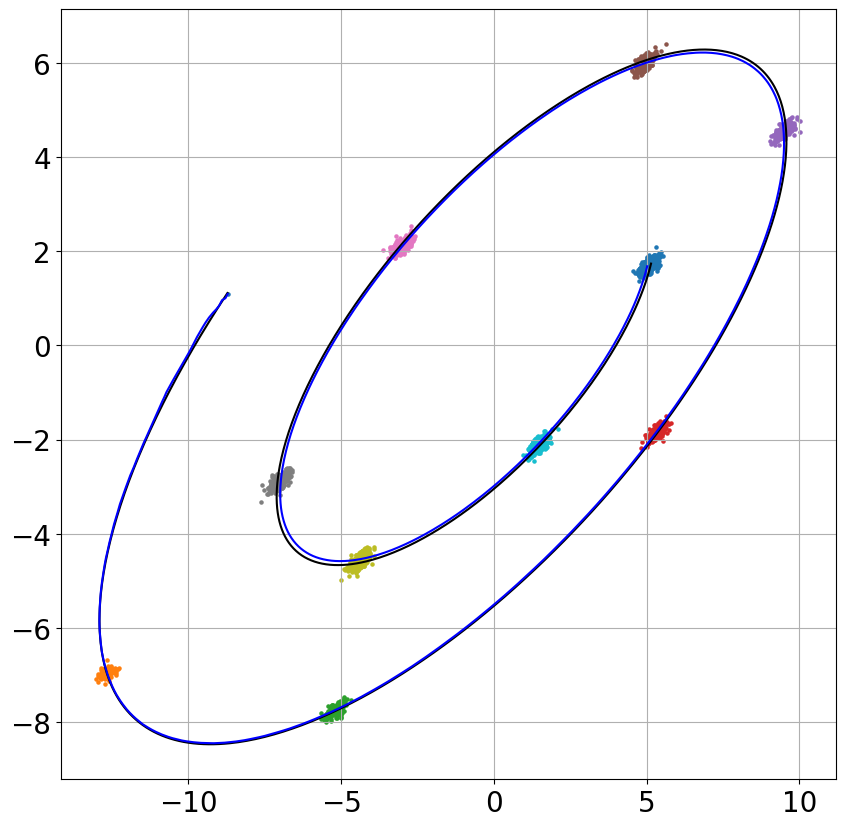

In [12]:
Xu = complex_matmul(Si1,X)
X_q = Xu
X_k = Xu
X_v = Xu
# K_exp = compute_kernel_v1(lambda_h, t_v, args)
K_exp, _ = compute_kernel(lambda_h, t_v)
X_ij_hat_all, R_qk_ij = compute_estimates_and_residuals_vectorized(X_q, X_k, X_v, K_exp, args)

# Get estimates, assuming no causal mask:
# X_avg = torch.mean(X_ij_hat_all,axis=2).unsqueeze(1)

# Get estimates, assuming causal mask:
tril_mask = torch.tril(torch.ones((args.seq_len, args.seq_len), dtype=torch.bool, device=X_ij_hat_all.device)).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
tril_mask_normalized = tril_mask/torch.sum(tril_mask, axis=2).unsqueeze(2)
# plt.imshow(tril_mask_normalized[0,:,:,0,0].cpu().numpy())
X_avg = torch.sum(tril_mask_normalized * X_ij_hat_all, axis=2)

X_true_plt = X_true.squeeze().detach().cpu().numpy()
Xo = complex_matmul(S1,X_ij_hat_all)[0].cpu().squeeze()
Xo_avg = complex_matmul(S1,X_avg).cpu()[0].squeeze().numpy()

for i in range(args.seq_len):
    if np.mod(i,int(args.seq_len/10)) == 0:
        x1 = Xo[i,0:i+1,:]
        plt.scatter(x1.T[0],x1.T[1], s=5)
# plt.plot(X_measure.squeeze().T[0].detach().cpu().numpy(),X_measure.squeeze().T[1].detach().cpu().numpy(),'black')
plt.plot(X_true_plt.T[0],X_true_plt.T[1],'black')
plt.plot(Xo_avg.T[0],Xo_avg.T[1],'blue')
plt.grid()
plt.show()

Test using every nth point as a measurement

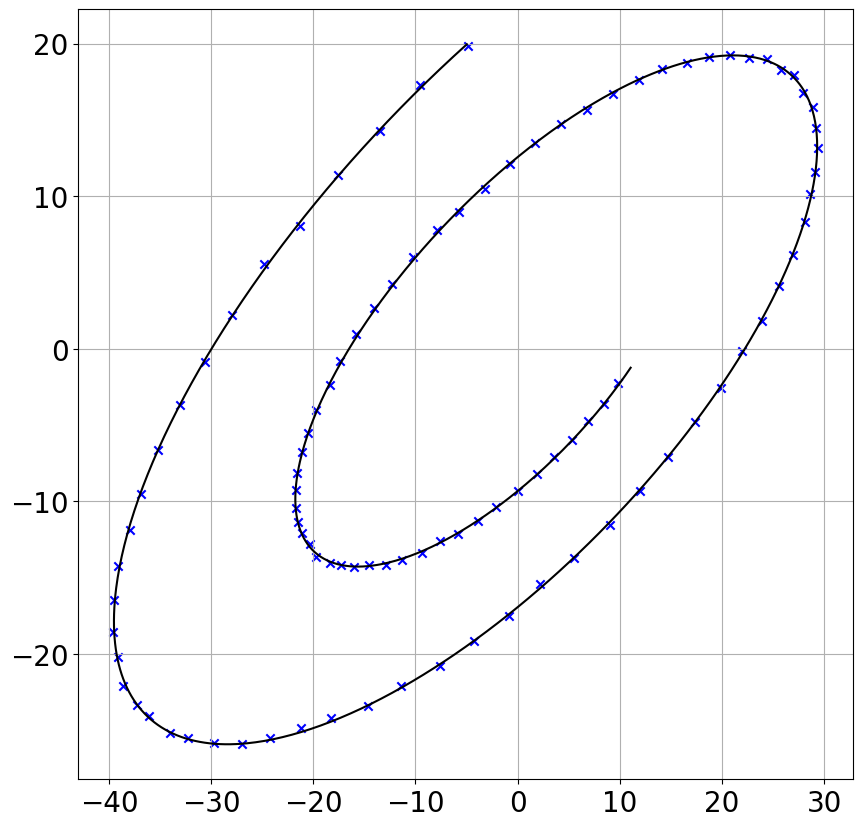

In [13]:
args.m = 2 # Dimension of system
args.tf = 10 # Final time
args.dt = 0.01 # Time step size
args.N_t = int(args.tf/args.dt) # Number of time steps
args.seq_len = 100

t_v = torch.linspace(0, args.tf, args.N_t).to(args.device) # Vector of times

x0 = (torch.randn(args.m)*10).unsqueeze(0).unsqueeze(-1).to(args.device) # Initial condition

X_true, X_measure_full = stochastic_LTI(A, x0, args.N_t, args, sigma_process=sigma_process, sigma_process_0=sigma_process_0, sigma_measure = sigma_measure) # Simulate system

# idxs, t_measure, X_measure = get_random_measurements(X_measure_full, t_v, args.seq_len)
idxs, t_measure, X_measure = get_nth_measurement(X_measure_full, t_v, args.N_t, n=10)

plt.plot(X_true.squeeze().T[0].detach().cpu().numpy(),X_true.squeeze().T[1].detach().cpu().numpy(), 'black')
plt.scatter(X_measure.squeeze().T[0].detach().cpu().numpy(),X_measure.squeeze().T[1].detach().cpu().numpy(), c='blue', marker='x')
plt.grid()
plt.show()

Map back through dynamics

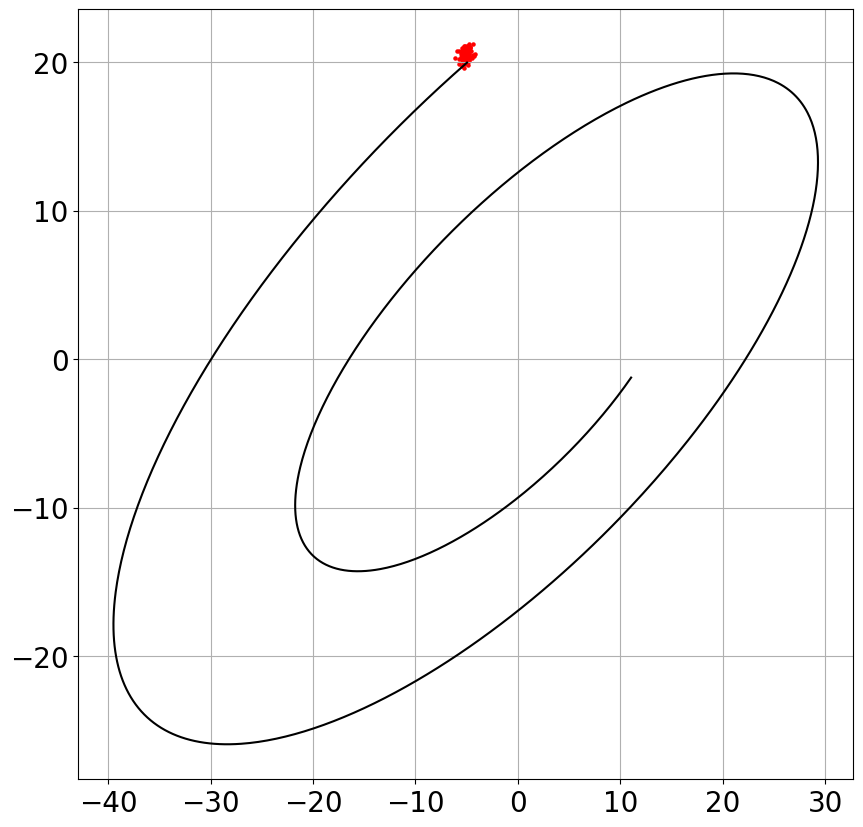

In [14]:
args.embed_dim = 2 # Embed dimension
args.d_v = args.embed_dim

# lambda for this system can be pulled from D
lambda_h = torch.randn(2, args.embed_dim).to(args.device)/10
lambda_h[0,0:2] = torch.diag(D1[0].squeeze())
lambda_h[1,0:2] = torch.diag(D1[1].squeeze())
lambda_h = lambda_h.unsqueeze(1).unsqueeze(-1)

# Matrix exponentials
mat_exp_f = complex_exp(lambda_h*t_measure.unsqueeze(0).unsqueeze(2).unsqueeze(3)) # Forward
mat_exp_b = complex_exp(-lambda_h*t_measure.unsqueeze(0).unsqueeze(2).unsqueeze(3)) # Backward

##############################

# Construct matrices to map between higher/lower dimensions

Pu = torch.zeros(2, args.embed_dim, args.m).to(args.device)
Pd = torch.zeros(2, args.m, args.embed_dim).to(args.device)

Pu = Pu.unsqueeze(1)
Pd = Pd.unsqueeze(1)

Pu[:,:,0:2,:] = Si1
Pd[:,:,:,0:2] = S1

##############################

# Generate vals with matrix exponential
# y1 = complex_matmul(Si1,X0) # Map to eigenbasis
# y2 = complex_hadamard(mat_exp_2f,y1) # Mat exp
# y3 = complex_matmul(S1,y2) # Back to original basis

# y3 = X_measure # Use simulated values from stochastic LTI
X = torch.zeros((2,X_measure.size()[0], X_measure.size()[1], X_measure.size()[2])).to(args.device)
X[0] = X_measure
y4 = complex_matmul(Pu,X) # Map to higher dim
y5 = complex_hadamard(mat_exp_b,y4) # Negative mat exp in higher dim
y6 = complex_matmul(Pd,y5) # Map back to lower dim

yi = X[0].squeeze().detach().cpu().numpy()
y = y6[0].squeeze().detach().cpu().numpy()

plt.plot(X_true.squeeze().T[0].detach().cpu().numpy(),X_true.squeeze().T[1].detach().cpu().numpy(), 'black')
plt.scatter(y.T[0],y.T[1],c='red',s=5)
# plt.plot(yi.T[0],yi.T[1],'black')
plt.grid()
plt.show()

# plt.scatter(x0.squeeze().cpu().numpy()[0],x0.squeeze().cpu().numpy()[1])
# plt.scatter(y.T[0],y.T[1], marker='x')
# plt.xlim(np.min(y.T[0]), np.max(y.T[0]))
# plt.ylim(np.min(y.T[1]), np.max(y.T[1]))
# plt.grid(1
# plt.show()

Plot state estimates in X_ij_hat_all

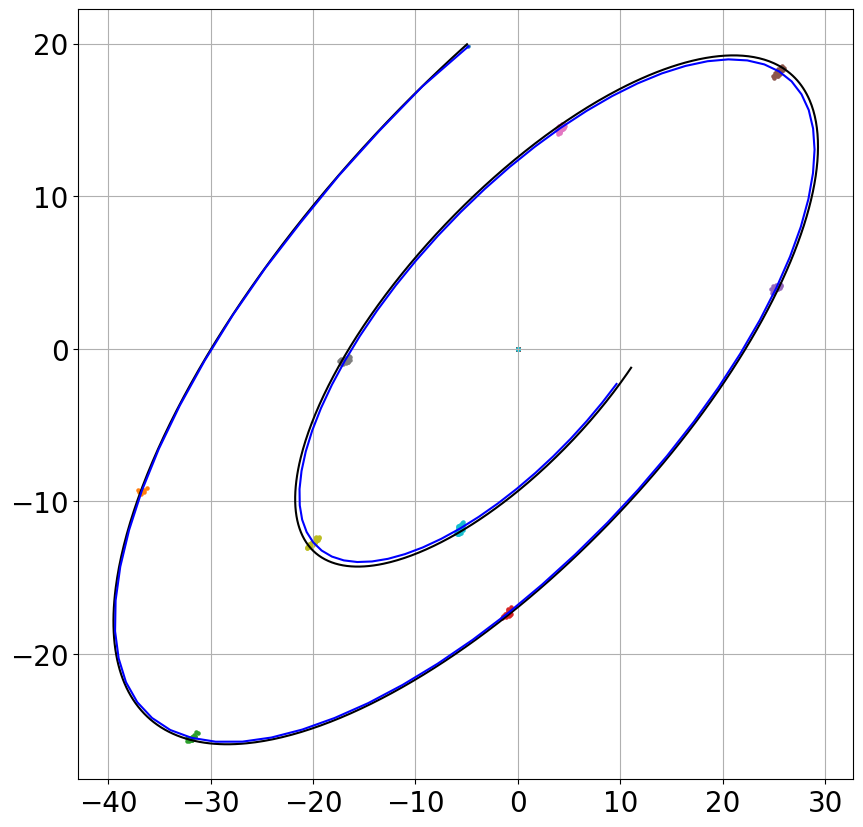

tensor([[[-4.9664],
         [19.9636]]], device='cuda:0')


In [15]:
# X = torch.zeros((2,X_measure_full.size()[0], X_measure_full.size()[1], X_measure_full.size()[2])).to(args.device)
# X[0] = X_measure_full
X = torch.zeros((2,X_measure.size()[0], X_measure.size()[1], X_measure.size()[2])).to(args.device)
X[0] = X_measure

Xu = complex_matmul(Si1,X)
X_q = Xu
X_k = Xu
X_v = Xu

# K_exp = compute_kernel_v1(lambda_h, t_v, args)
# K_exp = compute_kernel_v1(lambda_h, t_measure, args)
K_exp, _ = compute_kernel(lambda_h, t_measure)

X_ij_hat_all, R_qk_ij = compute_estimates_and_residuals_vectorized(X_q, X_k, X_v, K_exp, args)

# X_ij_hat_all, R_qk_ij = batched_compute_estimates_and_residuals_vectorized(X_q.unsqueeze(0), X_k.unsqueeze(0), X_v.unsqueeze(0), K_exp, args)
# X_ij_hat_all = X_ij_hat_all.squeeze(0)

# X_avg = torch.mean(X_ij_hat_all,axis=2).unsqueeze(1)
tril_mask = torch.tril(torch.ones((args.seq_len, args.seq_len), dtype=torch.bool, device=X_ij_hat_all.device)).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
tril_mask_normalized = tril_mask/torch.sum(tril_mask, axis=2).unsqueeze(2)
# plt.imshow(tril_mask_normalized[0,:,:,0,0].cpu().numpy())
X_avg = torch.sum(tril_mask_normalized * X_ij_hat_all, axis=2)

X_ij_hat_all.size()

X_true_plt = X_true.squeeze().detach().cpu().numpy()
Xo = complex_matmul(S1,X_ij_hat_all * tril_mask)[0].cpu().squeeze()
Xo_avg = complex_matmul(S1,X_avg).cpu()[0].squeeze().numpy()

Xo.size()

for i in range(args.seq_len):
  if np.mod(i,int(args.seq_len/10)) == 0:
    x1 = Xo[i,:,:]
    plt.scatter(x1.T[0],x1.T[1], s=5)
# plt.plot(X_measure.squeeze().T[0].detach().cpu().numpy(),X_measure.squeeze().T[1].detach().cpu().numpy(),'black')
plt.plot(X_true_plt.T[0],X_true_plt.T[1],'black')
plt.plot(Xo_avg.T[0],Xo_avg.T[1],'blue')
plt.grid()
plt.show()

print(x0)

In [16]:
# # WITH BATCHING

# args.seq_len = 100

# # X = torch.zeros((2,X_measure_full.size()[0], X_measure_full.size()[1], X_measure_full.size()[2])).to(args.device)
# # X[0] = X_measure_full
# X = torch.zeros((2,X_measure.size()[0], X_measure.size()[1], X_measure.size()[2])).to(args.device)
# X[0] = X_measure

# Xu = batched_complex_matmul(Si1,X.unsqueeze(0))
# X_q = Xu[:,:,0:100]
# X_k = Xu[:,:,0:100]
# X_v = Xu[:,:,0:100]

# args.embed_dim = 2 # Embed dimension

# # lambda for this system can be pulled from D
# lambda_h = torch.randn(2, args.embed_dim).to(args.device)/10
# lambda_h[0,0:2] = torch.diag(D1[0].squeeze())
# lambda_h[1,0:2] = torch.diag(D1[1].squeeze())
# lambda_h = lambda_h.unsqueeze(1).unsqueeze(-1)

# # K_exp = compute_kernel_v1(lambda_h, t_v, v)
# K_exp = compute_kernel_v1(lambda_h, t_measure[:-1], args)

# X_ij_hat_all, R_qk_ij = batched_compute_estimates_and_residuals_vectorized(X_q, X_k, X_v, K_exp, args)

# # X_ij_hat_all, R_qk_ij = batched_compute_estimates_and_residuals_vectorized(X_q.unsqueeze(0), X_k.unsqueeze(0), X_v.unsqueeze(0), K_exp, args)
# # X_ij_hat_all = X_ij_hat_all.squeeze(0)

# X_ij_hat_all.size()
# X_ij_hat_all = X_ij_hat_all.squeeze(0)

# X_avg = torch.mean(X_ij_hat_all,axis=2).unsqueeze(1)

# X_true_plt = X_true.squeeze().detach().cpu().numpy()
# Xo = complex_matmul(S1,X_ij_hat_all)[0].cpu().squeeze()
# Xo_avg = complex_matmul(S1,X_avg).cpu()[0].squeeze().numpy()

# Xo.size()

# for i in range(args.seq_len):
#   if np.mod(i,int(args.seq_len/10)) == 0:
#     x1 = Xo[i,:,:]
#     plt.scatter(x1.T[0],x1.T[1], s=5)
# # plt.plot(X_measure.squeeze().T[0].detach().cpu().numpy(),X_measure.squeeze().T[1].detach().cpu().numpy(),'black')
# plt.plot(X_true_plt.T[0],X_true_plt.T[1],'black')
# plt.plot(Xo_avg.T[0],Xo_avg.T[1],'blue')
# plt.grid()
# plt.show()

# print(x0)

Test compute_precision (using 2D model), plot precision matrix

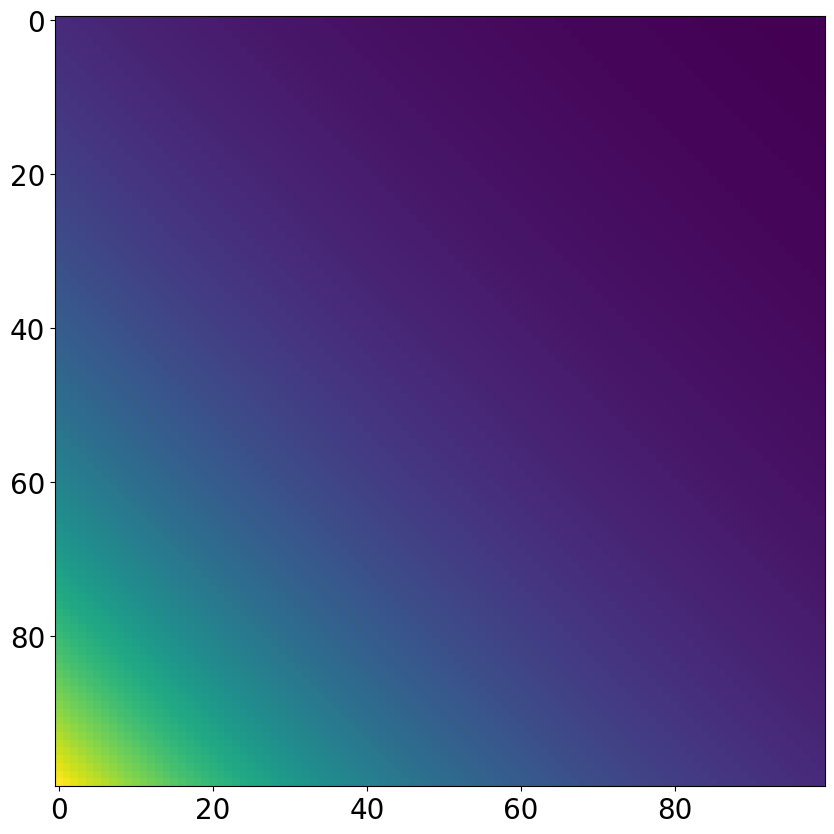

torch.Size([1, 100, 100, 2, 1])

In [17]:
args.nu = 0.1

# Set parameter matrices
lambda_Omega = sigma_process*torch.ones(1,args.m,1).to(args.device)
lambda_Omega0 = sigma_process*torch.ones(1,args.m,1).to(args.device)
lambda_C = 1.0*torch.ones(1,args.m,1).to(args.device)
lambda_Gamma = sigma_measure*torch.ones(1,args.m,1).to(args.device)

# tji_v = torch.concatenate((-t_v.flip(0)[:-1],t_v)) # Time differences vector
tji_v = torch.concatenate((-t_measure.flip(0)[:-1],t_measure)) # Time differences vector
 
P_ij = compute_precision_v1(lambda_h, lambda_Omega, lambda_Omega0, lambda_Gamma, tji_v, args)
# P_ij = compute_precision_tanh(lambda_h, lambda_Omega, lambda_Omega0, lambda_Gamma, tji_v, args)

# torch.Size([1, 100, 100, 2, 1])
# torch.Size([1, 100, 100, 2])

plt.imshow(P_ij[0,:,:,0,:].detach().cpu().numpy())
plt.show()

# plt.imshow(P_ij[0,:,:,1,:].detach().cpu().numpy())
# plt.show()

P_ij.size()

Test precise_attn with only measurement noise; plot attention matrix Q_ij

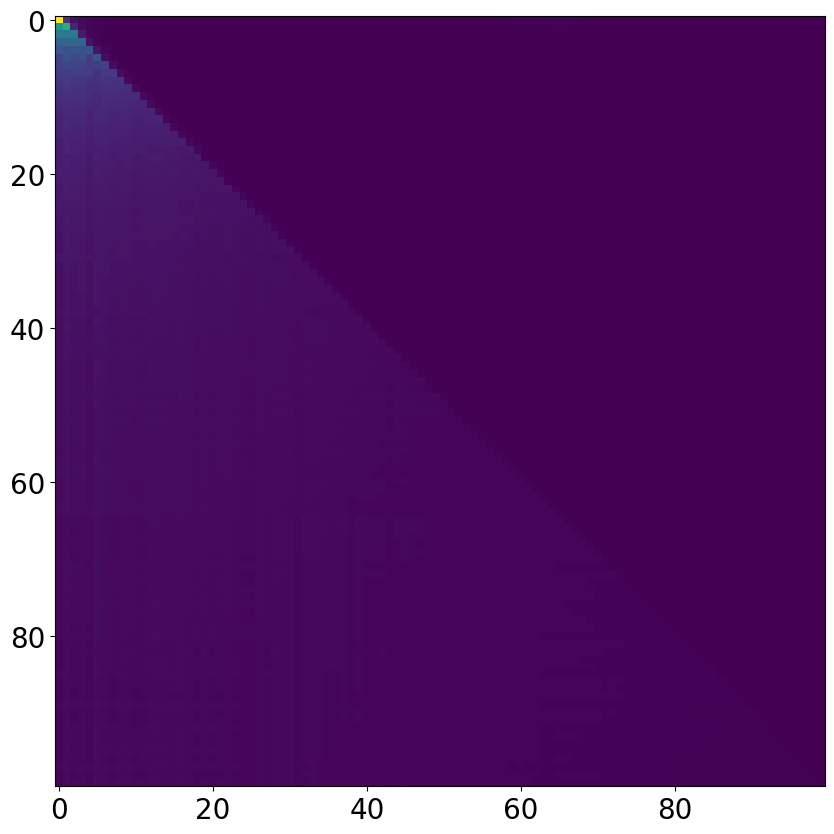

In [18]:
args.alpha = 1.0

args.nu = 0.1
# Set parameter matrices
lambda_Omega = sigma_process*torch.ones(1,args.m,1).to(args.device)
lambda_Omega0 = sigma_process*torch.ones(1,args.m,1).to(args.device)
lambda_C = 1.0*torch.ones(1,args.m,1).to(args.device)
lambda_Gamma = sigma_measure*torch.ones(1,args.m,1).to(args.device)

W_q = torch.stack((torch.eye(args.m,args.m), torch.zeros(args.m,args.m))).unsqueeze(1).to(args.device)
W_k = torch.stack((torch.eye(args.m,args.m), torch.zeros(args.m,args.m))).unsqueeze(1).to(args.device)
W_v = torch.stack((torch.eye(args.m,args.m), torch.zeros(args.m,args.m))).unsqueeze(1).to(args.device)
W_r = torch.stack((torch.eye(args.m,args.m), torch.zeros(args.m,args.m))).unsqueeze(1).to(args.device)
W_o = torch.stack((torch.eye(args.m,args.m), torch.zeros(args.m,args.m))).unsqueeze(1).to(args.device)

Xu = complex_matmul(Si1,X)
# out1, pred1, Q_ij, X_ij_hat_all = precise_attn(Xu, lambda_h, lambda_Omega, lambda_Omega0, lambda_C, lambda_Gamma, W_q, W_k, W_v, W_r, W_o, t_v, args)
out1, pred1, Q_ij, X_ij_hat_all = precise_attn(Xu, lambda_h, lambda_Omega, lambda_Omega0, lambda_C, lambda_Gamma, W_q, W_k, W_v, W_r, W_o, t_measure, args)
out = complex_matmul(S1,out1)

# Plot attention matrix
plt.imshow(Q_ij[0,:,:,0,:].detach().cpu().numpy())
plt.show()

Plot estimated trajectory

tensor([[[-4.9664],
         [19.9636]]], device='cuda:0')


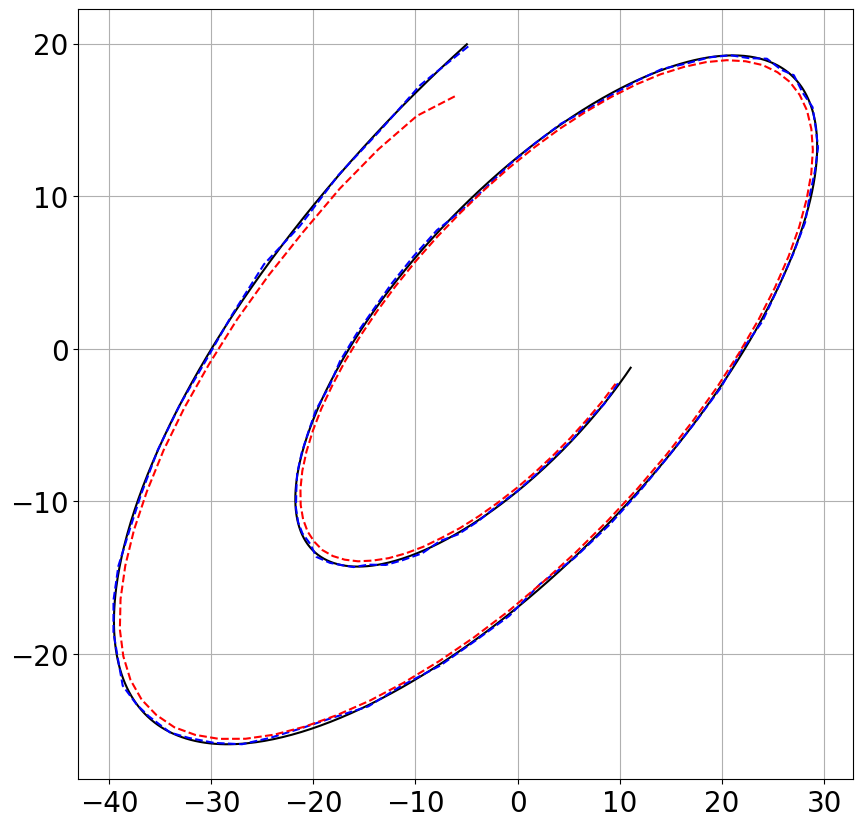

In [19]:
print(x0)

# Actual trajectory
plt.plot(X_true_plt.T[0],X_true_plt.T[1],'black')
# Noisy trajectory
traj = X[0].detach().cpu().squeeze().numpy().T
plt.plot(traj[0], traj[1],'b--')

out1_plt = out[0].detach().cpu().squeeze().numpy().T
plt.plot(out1_plt[0], out1_plt[1], 'r--')
plt.grid()
plt.show()

Test convergence when applied iteratively

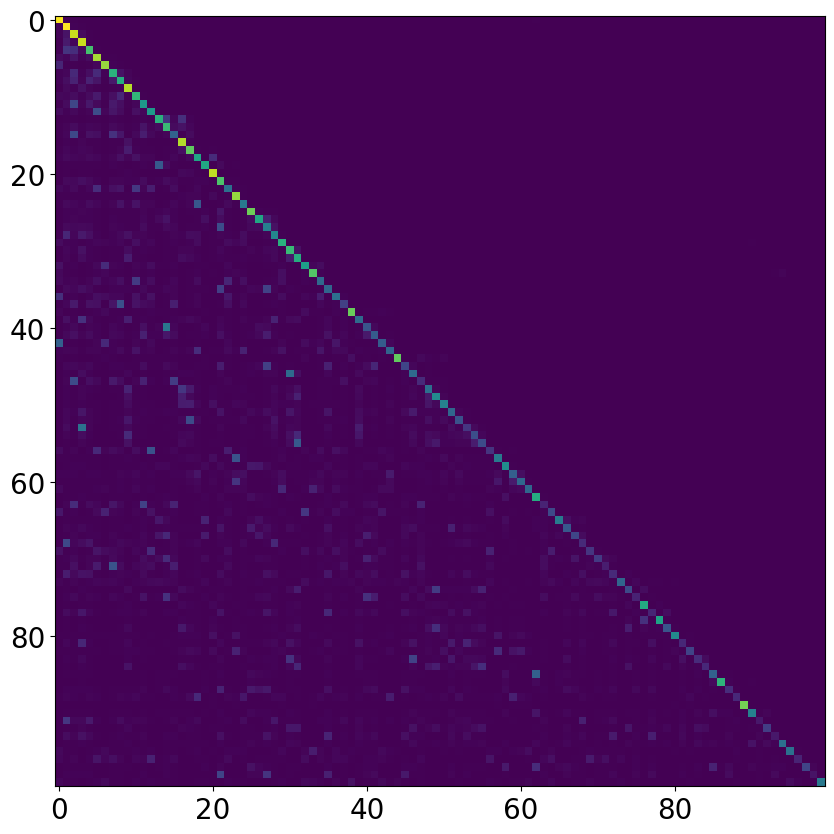

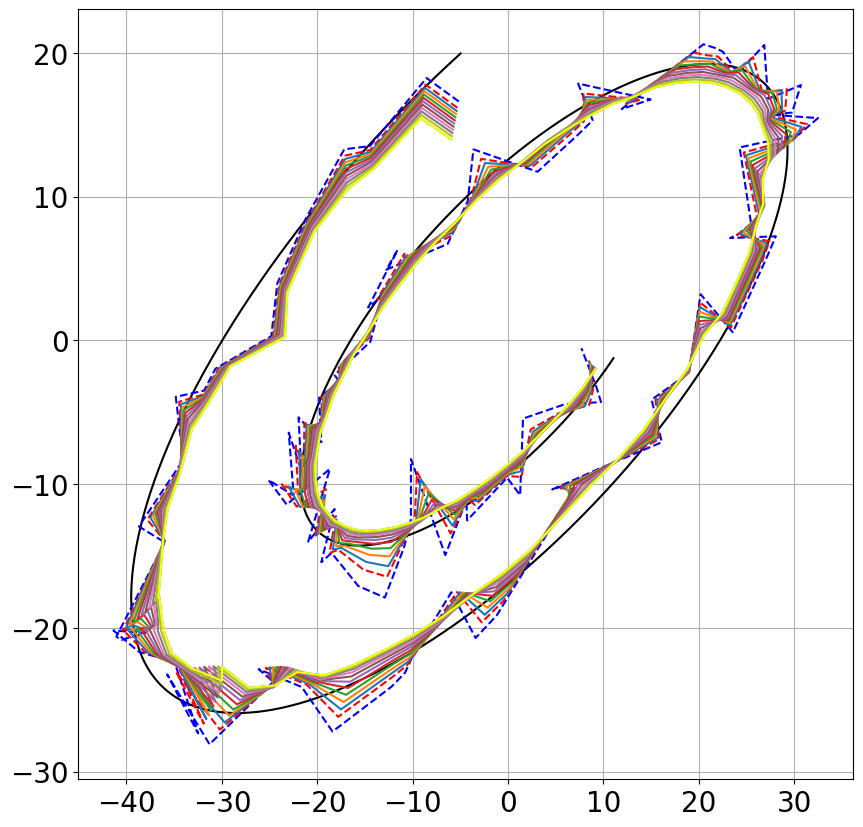

In [20]:
sigma_process = 0.0
sigma_process_0 = 0.0
sigma_measure = 2

X_true, X_measure_full = stochastic_LTI(A, x0, args.N_t, args, sigma_process=sigma_process, sigma_process_0=sigma_process_0, sigma_measure = sigma_measure) # Simulate system
idxs, t_measure, X_measure = get_nth_measurement(X_measure_full, t_v, args.N_t, n=10)

X = torch.zeros((2,X_measure.size()[0], X_measure.size()[1], X_measure.size()[2])).to(args.device)
X[0] = X_measure
X_true_plt = X_true.squeeze().detach().cpu().numpy()

sigma_process_model = sigma_process
sigma_measure_model = sigma_measure
sigma_process_0_model = sigma_process_0

args.nu = 1

Xu = complex_matmul(Si1,X)
# out1, pred1, Q_ij, _ = precise_attn(Xu, lambda_h, lambda_Omega, lambda_Omega0, lambda_C, lambda_Gamma, W_q, W_k, W_v, W_r, W_o, t_v, args)
out1, pred1, Q_ij, _ = precise_attn(Xu, lambda_h, lambda_Omega, lambda_Omega0, lambda_C, lambda_Gamma, W_q, W_k, W_v, W_r, W_o, t_measure, args)
out = complex_matmul(S1,out1)

# Plot attention matrix
plt.imshow(Q_ij[0,:,:,0,:].detach().cpu().numpy())
plt.show()

# Actual trajectory
plt.plot(X_true_plt.T[0],X_true_plt.T[1],'black')
# Noisy trajectory
traj = X[0].detach().cpu().squeeze().numpy().T
plt.plot(traj[0], traj[1], 'b--')

out1_plt = out[0].detach().cpu().squeeze().numpy().T
plt.plot(out1_plt[0], out1_plt[1], 'r--')

args.alpha = 0.5
for i in range(10):
  # Xi = beta*out + (1-beta)*X
  Xi = out
  Xiu = complex_matmul(Si1,Xi)
#   out1, _, _, _ = precise_attn(Xiu, lambda_h, lambda_Omega, lambda_Omega0, lambda_C, lambda_Gamma, W_q, W_k, W_v, W_r, W_o, t_v, args)
  out1, _, _, _ = precise_attn(Xiu, lambda_h, lambda_Omega, lambda_Omega0, lambda_C, lambda_Gamma, W_q, W_k, W_v, W_r, W_o, t_measure, args)
  out = complex_matmul(S1,out1)
  outi = out[0].detach().cpu().squeeze().numpy().T
  plt.plot(outi[0], outi[1])
outn_plt = out[0].detach().cpu().squeeze().numpy().T
plt.plot(outn_plt[0], outn_plt[1], 'yellow')

# X_mean = ((X_true[0] + X_true[-1])/2).squeeze().cpu().numpy()
# plt.xlim([X_mean[0] - 1 , X_mean[0] + 1])
# plt.ylim([X_mean[1] - 1 , X_mean[1] + 1])
# plt.xlim([25,30])
# plt.ylim([-5, 0])

plt.grid()
plt.show()

Test with process noise

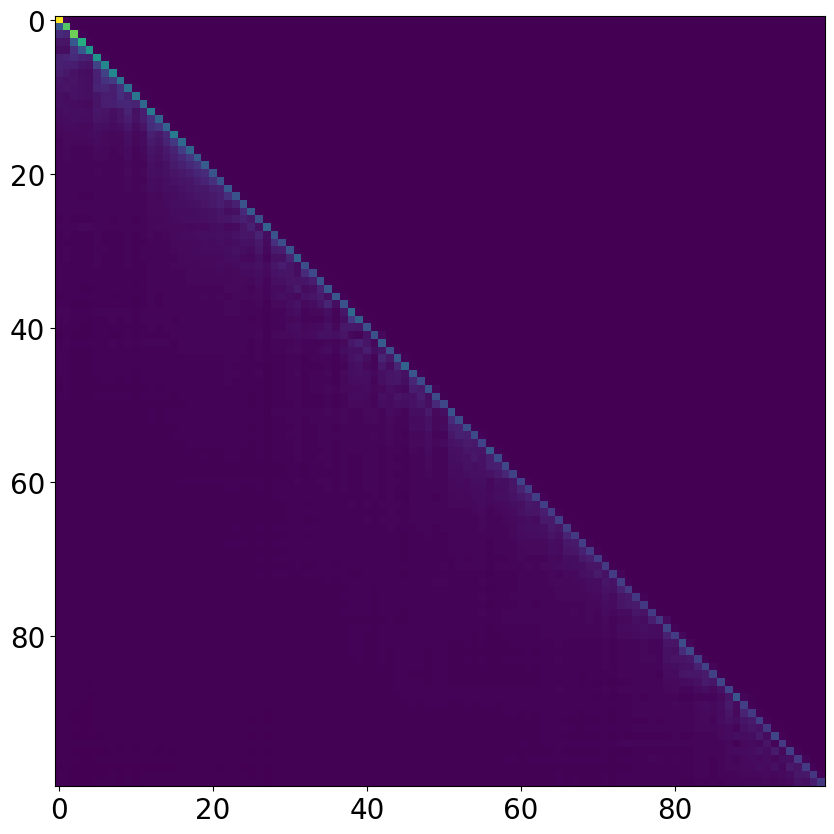

In [21]:
sigma_process = 0.5
sigma_process_0 = 0.5
sigma_measure = 0.2

X_true, X_measure_full = stochastic_LTI(A, x0, args.N_t, args, sigma_process=sigma_process, sigma_process_0=sigma_process_0, sigma_measure = sigma_measure) # Simulate system
idxs, t_measure, X_measure = get_nth_measurement(X_measure_full, t_v, args.N_t, n=10)

X = torch.zeros((2,X_measure.size()[0], X_measure.size()[1], X_measure.size()[2])).to(args.device)
X[0] = X_measure
X_true_plt = X_true.squeeze().detach().cpu().numpy()

sigma_process_model = sigma_process
sigma_measure_model = sigma_measure
sigma_process_0_model = sigma_process_0

args.nu = 10
# Set parameter matrices
lambda_Omega = sigma_process_model*torch.ones(1,args.m,1).to(args.device)
lambda_Omega0 = sigma_process_0_model*torch.ones(1,args.m,1).to(args.device)
lambda_C = 1.0*torch.ones(1,args.m,1).to(args.device)
lambda_Gamma = sigma_measure_model*torch.ones(1,args.m,1).to(args.device)

Xu = complex_matmul(Si1,X)
# out1, pred1, Q_ij, X_ij_hat_all = precise_attn(Xu, lambda_h, lambda_Omega, lambda_Omega0, lambda_C, lambda_Gamma, W_q, W_k, W_v, W_r, W_o, t_v, args)
out1, pred1, Q_ij, X_ij_hat_all = precise_attn(Xu, lambda_h, lambda_Omega, lambda_Omega0, lambda_C, lambda_Gamma, W_q, W_k, W_v, W_r, W_o, t_measure, args)
out = complex_matmul(S1,out1)

# Plot attention matrix
plt.imshow(Q_ij[0,:,:,0,:].detach().cpu().numpy())
plt.show()

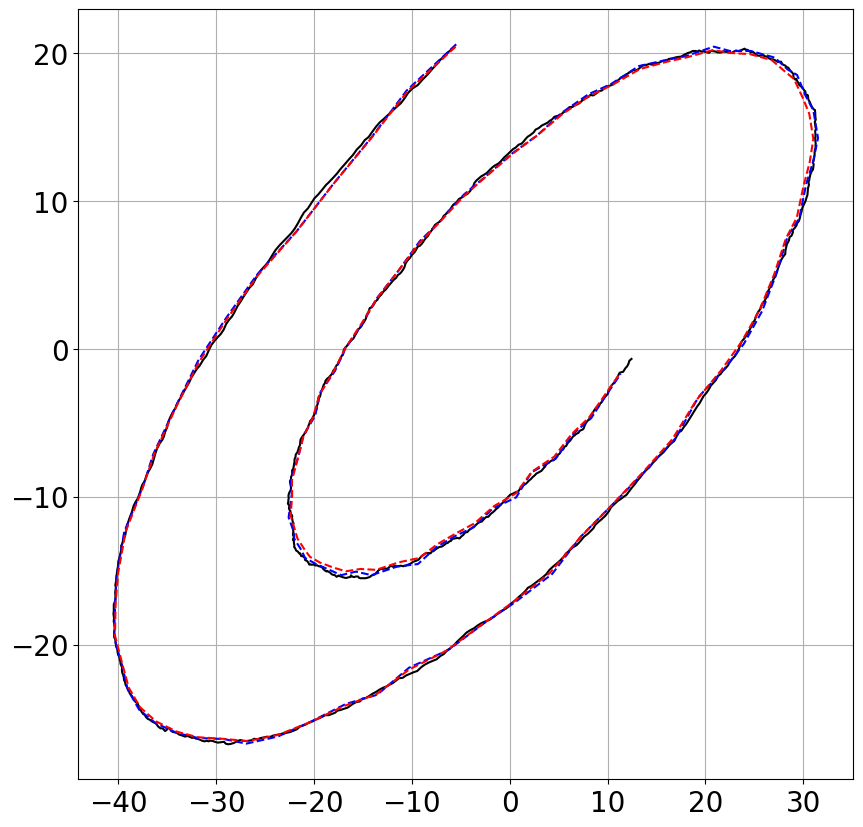

In [22]:
# Plot results

# Actual trajectory
plt.plot(X_true_plt.T[0],X_true_plt.T[1],'black')
# Noisy trajectory
traj = X[0].detach().cpu().squeeze().numpy().T
plt.plot(traj[0], traj[1], 'b--')

out1_plt = out[0].detach().cpu().squeeze().numpy().T
plt.plot(out1_plt[0], out1_plt[1], 'r--')
plt.grid()
plt.show()

In [ ]:
# # Test precise_attn_with_correction
# out2, pred2, Q_ij2 = precise_attn_with_correction(X, lambda_h, lambda_Omega, lambda_Omega0, lambda_C, lambda_Gamma, W_q, W_k, W_v, W_r, W_o, t_v, args)

# # Test precise_attn_full
# out3, pred3, Q_ij3 = precise_attn_full(X, lambda_h, lambda_Omega, lambda_Omega0, lambda_C, lambda_Gamma, W_q, W_k, W_v, W_r, W_o, t_v, args)

In [23]:
# # Actual trajectory
# plt.plot(X_true_plt.T[0],X_true_plt.T[1],'black')
# # Noisy trajectory
# traj = X[0].detach().cpu().squeeze().numpy().T
# plt.plot(traj[0], traj[1], 'b--')

# out1_plt = out[0].detach().cpu().squeeze().numpy().T
# plt.plot(out1_plt[0], out1_plt[1], 'r--')

# out2_plt = out2[0].detach().cpu().squeeze().numpy().T
# plt.plot(out2_plt[0], out2_plt[1], 'g')

# out3_plt = out3[0].detach().cpu().squeeze().numpy().T
# plt.plot(out3_plt[0], out3_plt[1], 'orange')

Test with higher dimensional system

In [25]:
args.embed_dim = 256 # Embed dimension
args.d_v = args.embed_dim

# lambda for this system can be pulled from D
lambda_h = torch.randn(2, args.embed_dim).to(args.device)/10
lambda_h[0,0:2] = torch.diag(D1[0].squeeze())
lambda_h[1,0:2] = torch.diag(D1[1].squeeze())
lambda_h = lambda_h.unsqueeze(1).unsqueeze(-1)

##############################

# Construct matrices to map between higher/lower dimensions

Pu = torch.zeros(2, 1, args.embed_dim, args.m).to(args.device)
Pd = torch.zeros(2, 1, args.m, args.embed_dim).to(args.device)

Pu[:,:,0:2,:] = Si1
Pd[:,:,:,0:2] = S1

##############################

y3 = X_measure # Use simulated values from stochastic LTI
X1 = torch.zeros((2,X_measure.size()[0], X_measure.size()[1], X_measure.size()[2])).to(args.device)
X1[0] = X_measure
X = complex_matmul(Pu,X1) # Map to higher dim

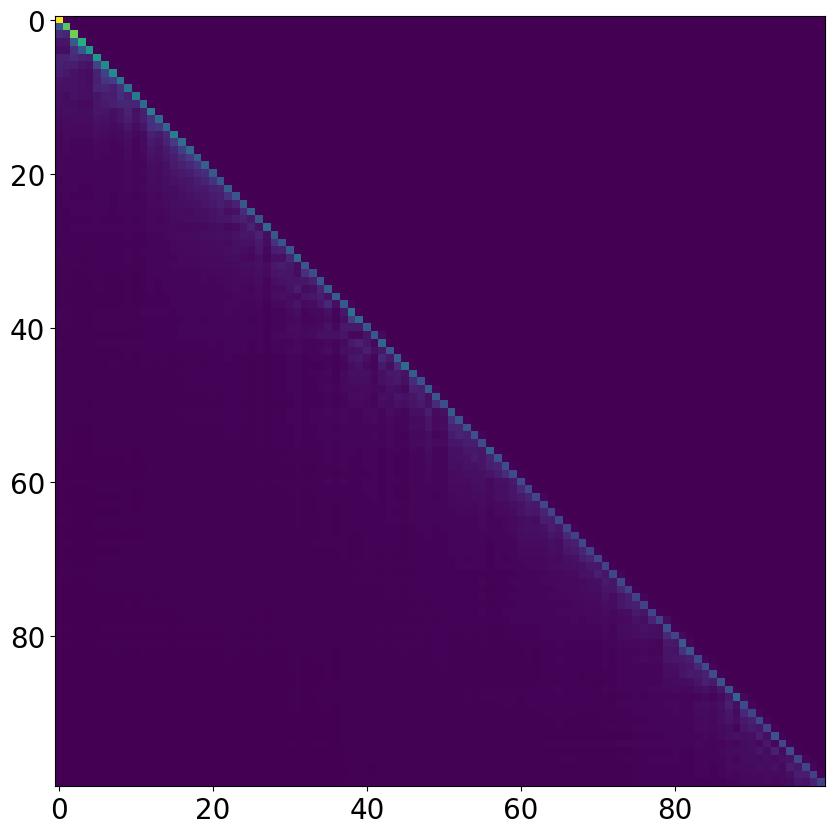

In [26]:
sigma_process_model = sigma_process
sigma_measure_model = sigma_measure
sigma_process_0_model = sigma_process_0

args.nu = 10
# Set parameter matrices
lambda_Omega = sigma_process_model*torch.ones(1,args.embed_dim,1).to(args.device)
lambda_Omega0 = sigma_process_0_model*torch.ones(1,args.embed_dim,1).to(args.device)
lambda_C = 1.0*torch.ones(1,args.embed_dim,1).to(args.device)
lambda_Gamma = sigma_measure_model*torch.ones(1,args.embed_dim,1).to(args.device)

W_q = torch.stack((torch.eye(args.embed_dim, args.embed_dim),torch.zeros(args.embed_dim, args.embed_dim))).unsqueeze(1).to(args.device)
W_k = torch.stack((torch.eye(args.embed_dim, args.embed_dim),torch.zeros(args.embed_dim, args.embed_dim))).unsqueeze(1).to(args.device)
W_v = torch.stack((torch.eye(args.embed_dim, args.embed_dim),torch.zeros(args.embed_dim, args.embed_dim))).unsqueeze(1).to(args.device)
W_r = torch.stack((torch.eye(args.embed_dim, args.embed_dim),torch.zeros(args.embed_dim, args.embed_dim))).unsqueeze(1).to(args.device)
W_o = torch.stack((torch.eye(args.embed_dim, args.embed_dim),torch.zeros(args.embed_dim, args.embed_dim))).unsqueeze(1).to(args.device)

# out1, pred1, Q_ij, X_ij_hat_all = precise_attn(X, lambda_h, lambda_Omega, lambda_Omega0, lambda_C, lambda_Gamma, W_q, W_k, W_v, W_r, W_o, t_v, args)
out1, pred1, Q_ij, X_ij_hat_all = precise_attn(X, lambda_h, lambda_Omega, lambda_Omega0, lambda_C, lambda_Gamma, W_q, W_k, W_v, W_r, W_o, t_measure, args)
out = complex_matmul(Pd,out1) # Map back to lower dim

# Plot attention matrix
Q_ij_avg = torch.mean(Q_ij[0],axis=2)
plt.imshow(Q_ij_avg.detach().cpu().numpy())
plt.show()

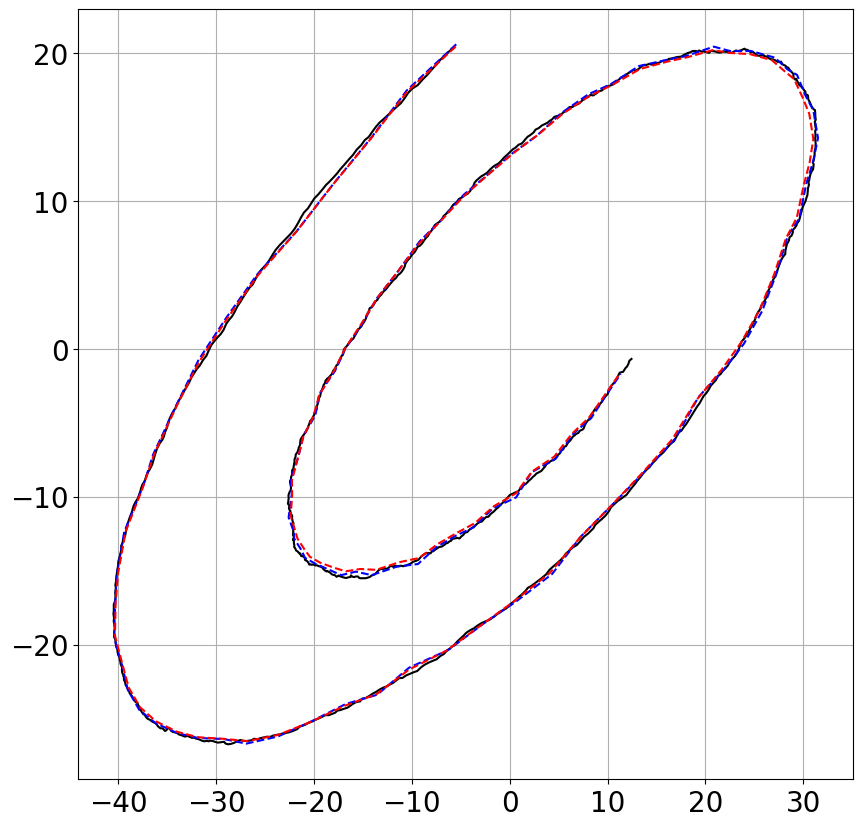

In [27]:
# Plot results

# Actual trajectory
plt.plot(X_true_plt.T[0],X_true_plt.T[1],'black')
# Noisy trajectory
traj = X_measure.detach().cpu().squeeze().numpy()
plt.plot(traj.T[0], traj.T[1], 'b--')

out1_plt = out[0].detach().cpu().squeeze().numpy()
plt.plot(out1_plt.T[0], out1_plt.T[1], 'r--')
plt.grid()
plt.show()